This is how much space the figure will take up on letter paper


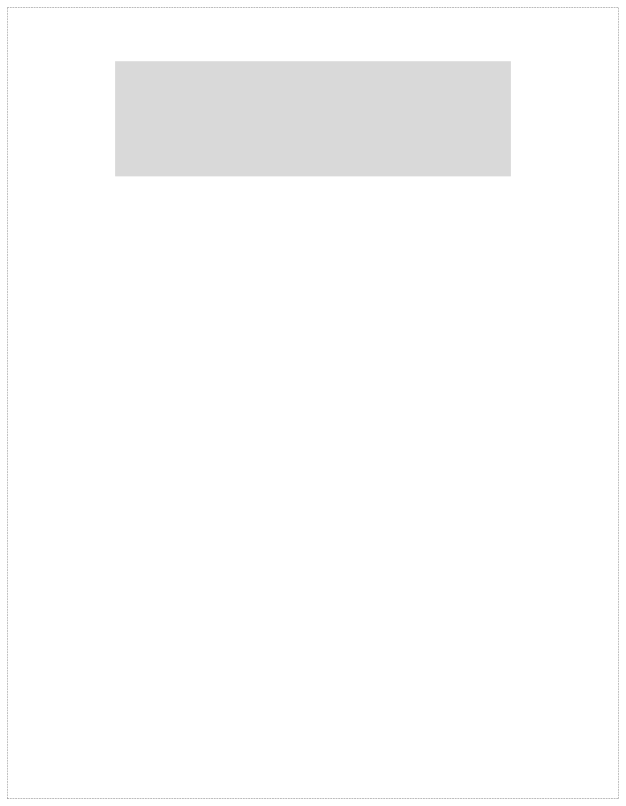

In [1]:
__PRODUCTION__ = 0
__NAME__       = 'graph_kernel'
__WIDTH__      = 5.5  # NeurIPS 2021 text box width
__HEIGHT__     = 1.6

if __PRODUCTION__:
    from mplmagic import pgf
else:
    from mplmagic import svg

from mplmagic.util import SuperFigure, SuperAxes, size_hint
import matplotlib.pyplot as plt

print('This is how much space the figure will take up on letter paper')
size_hint(__WIDTH__, __HEIGHT__, margin_left=0.5 * (8.5 - __WIDTH__));

In [2]:
import functools
import numpy as np
from scipy.ndimage import gaussian_filter1d
from scipy.spatial.distance import cdist
import torch
import torch.nn.functional as F
from torch import optim
import pickle
from symfac.experimental import RBFExpansionV2
from symfac.experimental import RBFExpansionMiniBatch
import timeit

In [3]:
d_tensor = torch.load('d1')

In [4]:
d_tensor.shape

torch.Size([256, 256])

In [5]:
target = torch.tensor(d_tensor, dtype=torch.float)

<ipython-input-5-1f4127bc6c9b>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(d_tensor, dtype=torch.float)


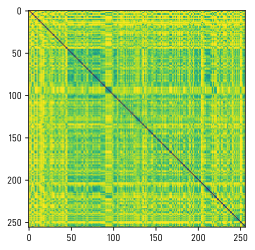

In [6]:
plt.imshow(target)

In [7]:
bs = 50
N = 256
num_iters = 25000

In [8]:
open('graph_kernel_pic.pickle', 'wb').write(pickle.dumps(target))

262560

100%|██████████| 25000/25000 [01:02<00:00, 399.66it/s]


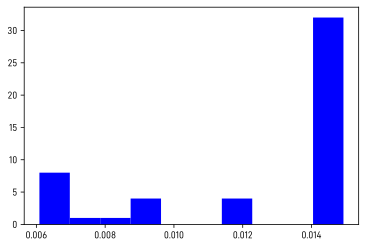

0.0060881


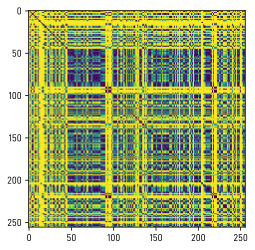

100%|██████████| 25000/25000 [01:38<00:00, 252.99it/s]


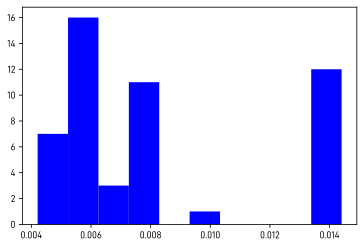

0.0042106


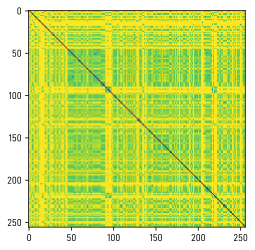

100%|██████████| 25000/25000 [02:26<00:00, 170.30it/s]


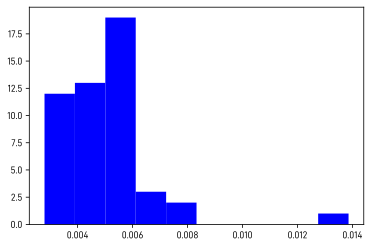

0.0027955


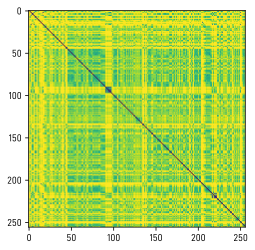

100%|██████████| 25000/25000 [02:49<00:00, 147.67it/s]


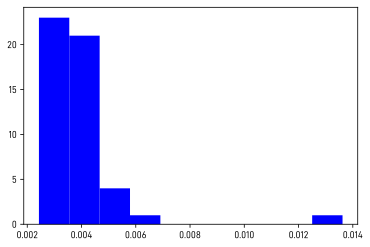

0.0024306


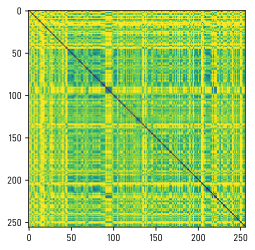

100%|██████████| 25000/25000 [03:46<00:00, 110.34it/s]


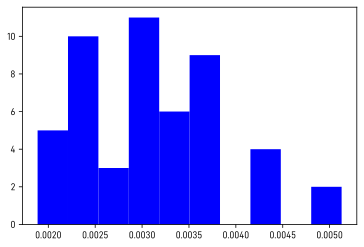

0.0018857


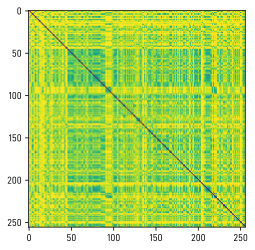

100%|██████████| 25000/25000 [04:10<00:00, 99.66it/s] 


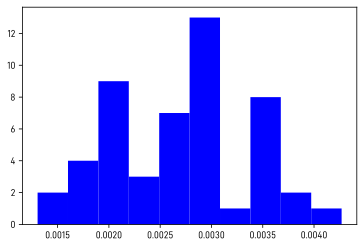

0.0013048


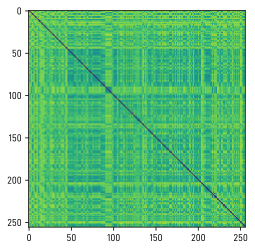

100%|██████████| 25000/25000 [05:04<00:00, 81.98it/s]


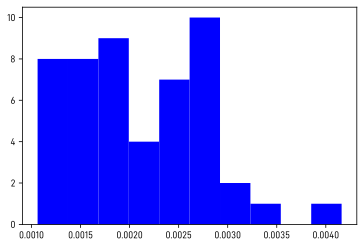

0.0010621


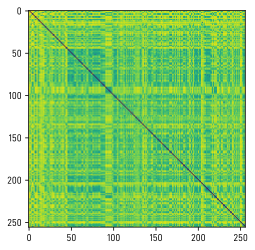

100%|██████████| 25000/25000 [05:10<00:00, 80.59it/s]


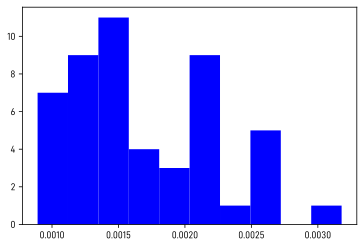

0.0008916


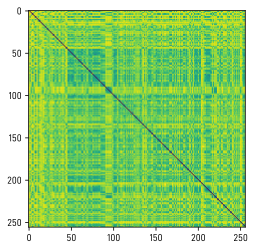

100%|██████████| 25000/25000 [06:23<00:00, 65.20it/s]


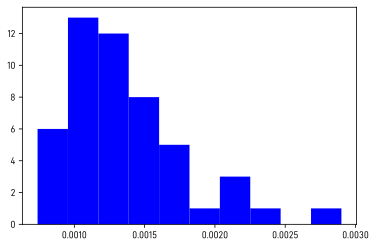

0.0007387


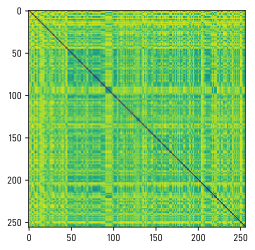

100%|██████████| 25000/25000 [06:53<00:00, 60.45it/s]


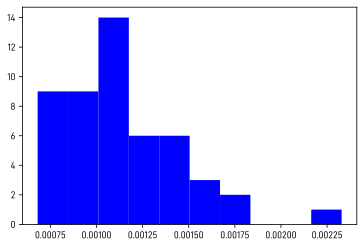

0.0006812


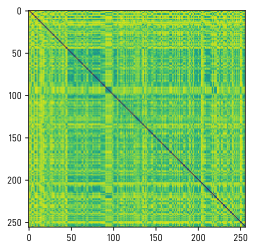

[0.0060881, 0.0042106, 0.0027955, 0.0024306, 0.0018857, 0.0013048, 0.0010621, 0.0008916, 0.0007387, 0.0006812]


In [22]:
errors = []
times = []
for k in range(1,11):
    start = timeit.timeit()
    u0=1/1000*torch.randn([bs, len(target), k], device="cuda") 
    a=torch.randn([bs, k], device="cuda")
    b=torch.randn([bs], device="cuda")
    fac = RBFExpansionV2(k=k, batch_size=bs, max_steps=num_iters)
    fac.fith(
        target,
        u0=u0,
        a0=a,
        b0=b
    )
    plt.hist(fac.report.loss_best, color='b', label='1')
    plt.show()

    plt.show()
    error = fac.report.loss_best
    er = round(float(torch.min(error).cpu().detach().numpy()), 7)
    print(er)
    errors.append(er)
    end = timeit.timeit()
    times.append(end - start)
    plt.imshow(fac.optimum(runs=torch.argmin(fac.report.loss_best)))
    plt.show()
    open('fac_kernel_{0}.pickle'.format(k), 'wb').write(pickle.dumps(fac.optimum.x))
print(errors)


In [24]:
times

[-0.009032121044583619,
 0.00016613001935184002,
 -4.404212813824415e-05,
 2.9369955882430077e-05,
 -0.0007530710427090526,
 1.8210848793387413e-06,
 1.5888013876974583e-05,
 1.3360055163502693e-05,
 0.0008659530431032181,
 2.249889075756073e-05]

In [19]:
open('graph_kernel_losses.pickle', 'wb').write(pickle.dumps(errors))

5454

Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does n

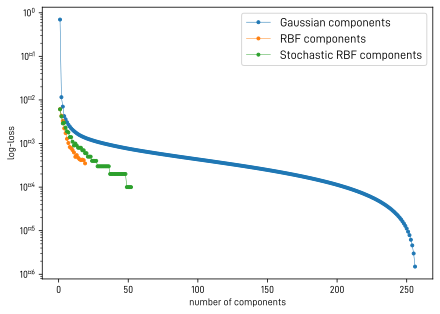

In [95]:
plt.figure(figsize=(7, 5))
plt.plot(range(1, target.shape[0]+1), s_vals, '.-', label='Gaussian components')
plt.plot(range(1, len(errors)+1), errors, '.-', label='RBF components')
plt.plot(range(1, len(rgb_sgd)+1), rgb_sgd, '.-', label='Stochastic RBF components')
plt.ylabel('log-loss')
plt.yscale('log')
plt.xlabel('number of components')
plt.legend(loc='upper right', fontsize=12)
#plt.title('Graph kernel 256*256')
plt.show()

In [21]:
def find_svd(X,s):
    U, S, V = np.linalg.svd(X.detach().numpy())
    return round(float(F.mse_loss(torch.tensor((U[:, :s] * S[None, :s]) @ V[:s, :]), X)), 7)

In [88]:
open('gk_losses.pickle', 'wb').write(pickle.dumps([errors, errors_mini[:10], s_vals[1:11]]))

298

In [22]:
s_vals = []
for s in range(target.shape[0]):
    s_vals.append(find_svd(target, s))

In [15]:
len(s_vals)

256

In [11]:
open('graph_kernel_svd.pickle', 'wb').write(pickle.dumps(s_vals[1:]))

2311

In [47]:
errors

[0.0060881,
 0.0042106,
 0.0027955,
 0.0024306,
 0.0018857,
 0.0013048,
 0.0010621,
 0.0008916,
 0.0007387,
 0.0006812]

In [41]:
errors_mini

[0.0061804,
 0.0046355,
 0.0038087,
 0.0030982,
 0.0021956,
 0.0021081,
 0.0014806,
 0.0015258,
 0.0010862,
 0.0010517,
 0.0009961,
 0.0009438,
 0.0008429,
 0.0007509,
 0.0006723,
 0.0006414,
 0.0007446,
 0.0006746,
 0.0006916]

In [50]:
a

[0.0061,
 0.0042,
 0.0029,
 0.003,
 0.0023,
 0.0019,
 0.0018,
 0.0014,
 0.0014,
 0.0011,
 0.0009,
 0.001,
 0.0009,
 0.0008,
 0.0008,
 0.0008,
 0.0007,
 0.0007,
 0.0006,
 0.0006,
 0.0005,
 0.0005,
 0.0005,
 0.0004,
 0.0004,
 0.0004,
 0.0004,
 0.0003,
 0.0003,
 0.0003,
 0.0003,
 0.0003,
 0.0003,
 0.0003,
 0.0003,
 0.0003,
 0.0002,
 0.0002,
 0.0002,
 0.0002,
 0.0002,
 0.0002,
 0.0002,
 0.0002,
 0.0002,
 0.0002,
 0.0002,
 0.0002,
 0.0001,
 0.0001,
 0.0001,
 0.0001]

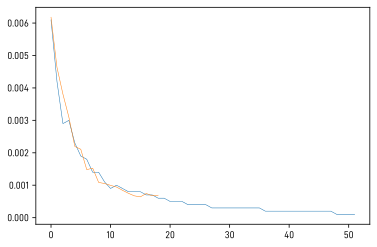

In [51]:
plt.plot(range(len(a)), a, range(len(errors_mini)), errors_mini)

In [49]:
a = pickle.load(open('graph_kernel_sgd_losses.pickle', "rb"))

  0%|          | 0/25000 [00:00<?, ?it/s]

1


100%|██████████| 25000/25000 [01:06<00:00, 374.83it/s]


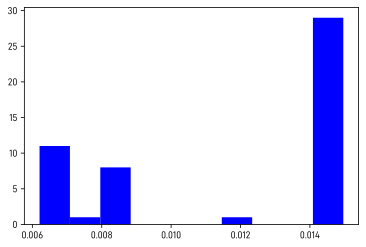

0.0062075


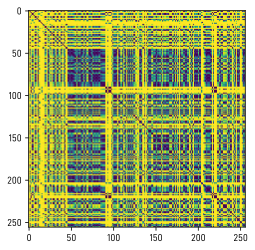

  0%|          | 0/25000 [00:00<?, ?it/s]

2


100%|██████████| 25000/25000 [00:55<00:00, 449.92it/s]


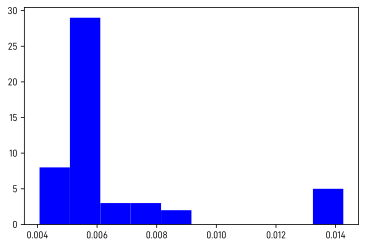

0.0040708


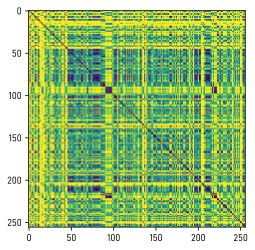

  0%|          | 0/25000 [00:00<?, ?it/s]

3


100%|██████████| 25000/25000 [00:56<00:00, 441.01it/s]


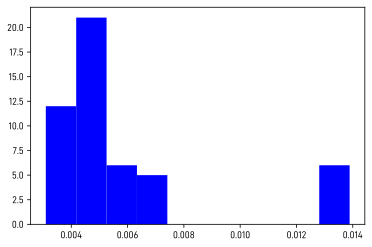

0.0030945


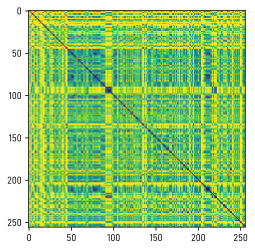

  0%|          | 0/25000 [00:00<?, ?it/s]

4


100%|██████████| 25000/25000 [00:57<00:00, 434.94it/s]


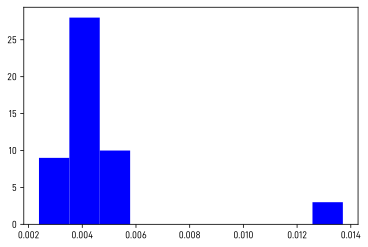

0.002387


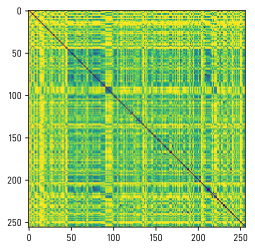

  0%|          | 0/25000 [00:00<?, ?it/s]

5


100%|██████████| 25000/25000 [00:53<00:00, 468.86it/s]


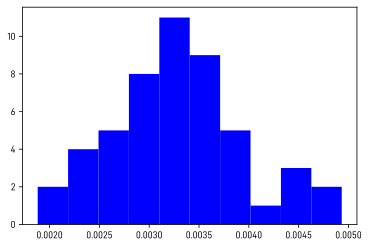

0.0018811


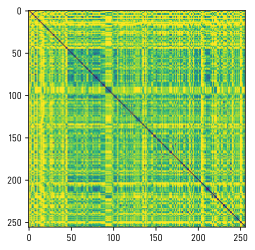

  0%|          | 0/25000 [00:00<?, ?it/s]

6


100%|██████████| 25000/25000 [00:54<00:00, 457.58it/s]


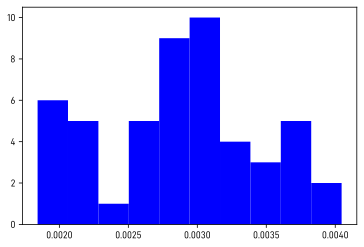

0.0018422


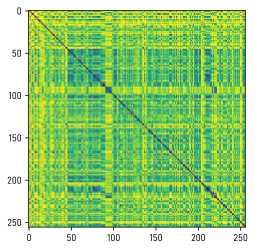

  0%|          | 0/25000 [00:00<?, ?it/s]

7


100%|██████████| 25000/25000 [00:55<00:00, 452.18it/s]


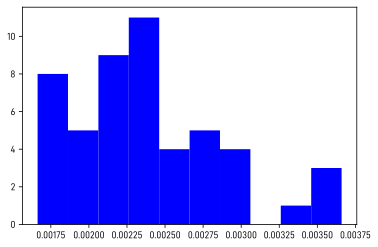

0.0016631


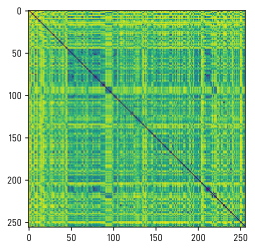

  0%|          | 0/25000 [00:00<?, ?it/s]

8


100%|██████████| 25000/25000 [00:58<00:00, 426.80it/s]


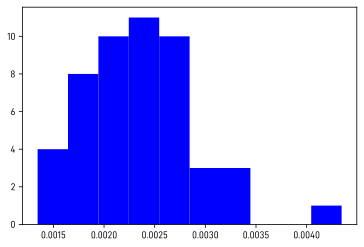

0.0013441


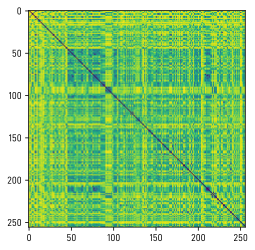

  0%|          | 0/25000 [00:00<?, ?it/s]

9


100%|██████████| 25000/25000 [00:59<00:00, 422.36it/s]


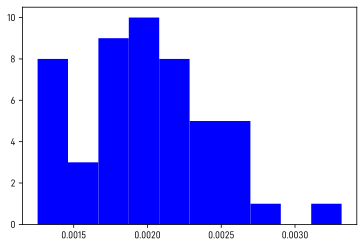

0.0012553


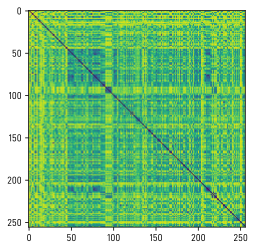

  0%|          | 0/25000 [00:00<?, ?it/s]

10


100%|██████████| 25000/25000 [01:02<00:00, 401.71it/s]


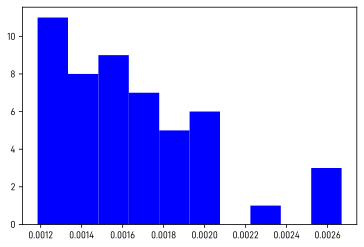

0.001185


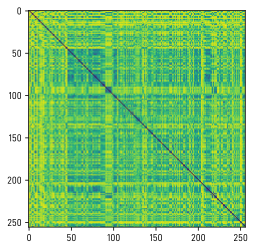

  0%|          | 0/25000 [00:00<?, ?it/s]

11


100%|██████████| 25000/25000 [01:03<00:00, 396.19it/s]


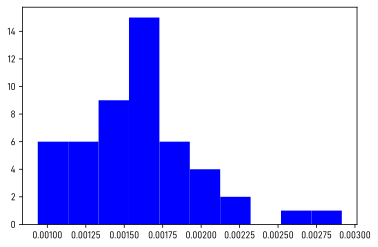

0.0009378


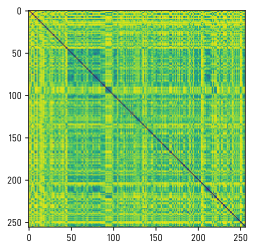

  0%|          | 0/25000 [00:00<?, ?it/s]

12


100%|██████████| 25000/25000 [01:05<00:00, 383.99it/s]


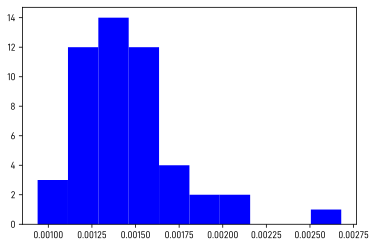

0.0009386


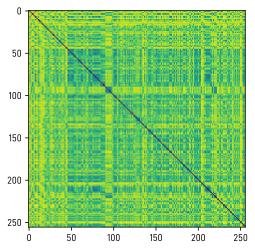

  0%|          | 0/25000 [00:00<?, ?it/s]

13


100%|██████████| 25000/25000 [01:09<00:00, 361.77it/s]


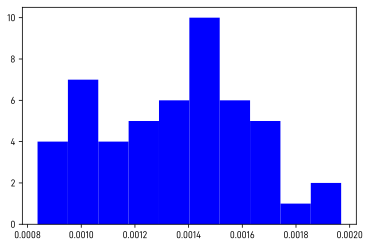

0.0008372


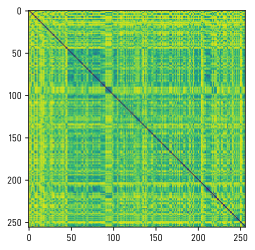

  0%|          | 0/25000 [00:00<?, ?it/s]

14


100%|██████████| 25000/25000 [01:11<00:00, 349.45it/s]


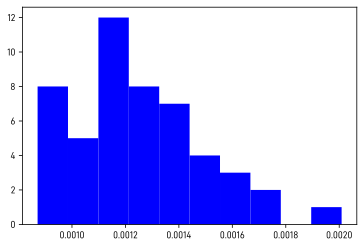

0.0008714


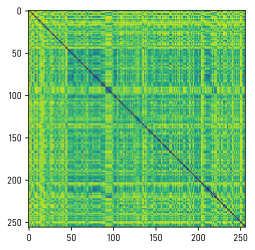

  0%|          | 0/25000 [00:00<?, ?it/s]

15


100%|██████████| 25000/25000 [01:15<00:00, 331.39it/s]


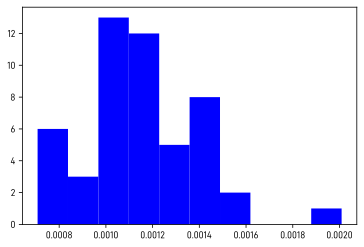

0.0007076


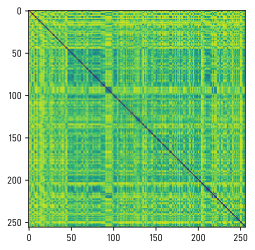

  0%|          | 0/25000 [00:00<?, ?it/s]

16


100%|██████████| 25000/25000 [01:19<00:00, 315.11it/s]


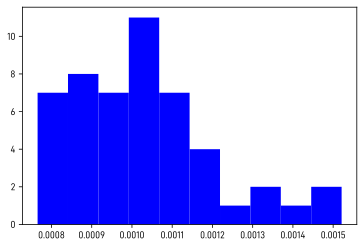

0.0007655


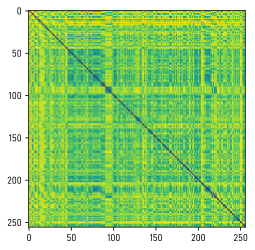

  0%|          | 0/25000 [00:00<?, ?it/s]

17


100%|██████████| 25000/25000 [01:25<00:00, 292.94it/s]


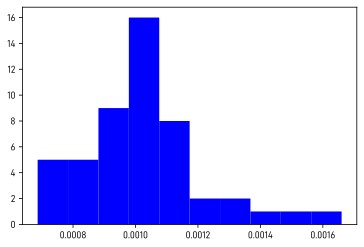

0.0006867


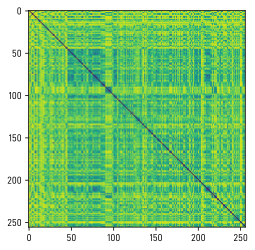

  0%|          | 0/25000 [00:00<?, ?it/s]

18


100%|██████████| 25000/25000 [01:28<00:00, 283.34it/s]


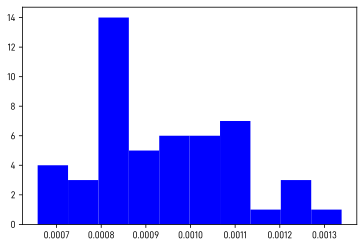

0.0006576


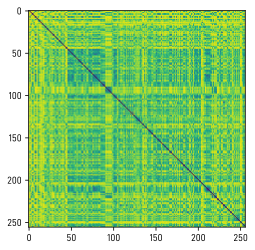

  0%|          | 0/25000 [00:00<?, ?it/s]

19


100%|██████████| 25000/25000 [01:31<00:00, 271.99it/s]


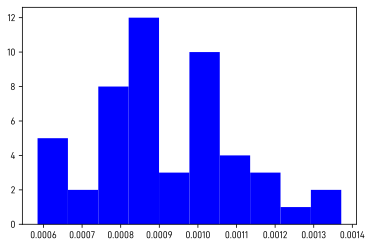

0.0005847


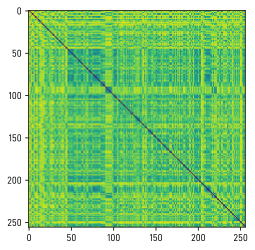

[0.0062075, 0.0040708, 0.0030945, 0.002387, 0.0018811, 0.0018422, 0.0016631, 0.0013441, 0.0012553, 0.001185, 0.0009378, 0.0009386, 0.0008372, 0.0008714, 0.0007076, 0.0007655, 0.0006867, 0.0006576, 0.0005847]


In [12]:
errors_mini_2 = []
for k in range(1,20):
#for k in [20,40,60,80,100,120,140,160,180,200,220,240]:
    print(k)
    u0=1/1000*torch.randn([bs, target.shape[0], k], device="cuda") 
    a=torch.randn([bs, k], device="cuda")
    b=torch.randn([bs], device="cuda")
    fac_mini = RBFExpansionMiniBatch(k=k, mini_batch_size= 8 * target.shape[0], batch_size=bs, max_steps=num_iters, mini_batch_by='elements')
    

    fac_mini.fit_custom(
        target,
        f=lambda u, a, b:
            torch.sum(
                fac_mini.rbf(u[..., :, None, :] - u[..., None, :, :]) *
                a[..., None, None, :],
                dim=-1
            ) + b[..., None, None],
        f_minibatch=lambda i, j, u, a, b:
            torch.sum(
                fac_mini.rbf(u[..., i, :] - u[..., j, :]) * a[..., None, :],
            dim=-1
        ) + b[..., None],
        seed=0,
        u=0.001 * fac_mini.randn(fac_mini.batch_size, target.shape[0], fac_mini.k),
        a=fac_mini.randn(fac_mini.batch_size, fac_mini.k),
        b=fac_mini.randn(fac_mini.batch_size)
)
    plt.hist(fac_mini.report.loss_best, color='b', label='1')
    plt.show()

    plt.show()
    error = fac_mini.report.loss_best
    er = round(float(torch.min(error).cpu().detach().numpy()), 7)
    print(er)
    errors_mini_2.append(er)
    plt.imshow( fac_mini.optimum(runs=torch.argmin( fac_mini.report.loss_best)))
    plt.show()
    open('fac_mini_kernel_{0}.pickle'.format(k), 'wb').write(pickle.dumps(fac_mini.optimum.x))
print(errors_mini_2)



In [69]:
times_mini = [63/60, 50/60, 52/60, 56/60, 50/60, 52/60, 58/60, 61/60, 64/60, 67/60]

In [70]:
times = [62/60, 98/60, 146/60, 169/60, 226/60, 250/60, 304/60, 310/60, 383/60, 413/60]

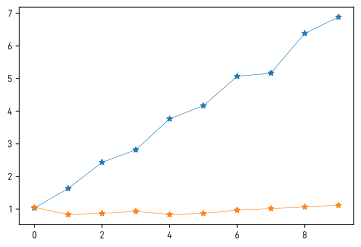

In [71]:
plt.plot(range(10), times,'*-' , range(10), times_mini,'*-' )

In [10]:
errors_mini_2

[0.0005691,
 0.0002283,
 0.0001303,
 0.0001106,
 0.000112,
 0.0001076,
 0.0001042,
 0.0001062]

In [11]:
 0.0006358,
 0.0002089,
 0.0001358,
 0.0001128,
 0.0001089,
 0.0001019,
 0.0001083,
 0.0001056

NameError: name 'errors_mini_1' is not defined

In [14]:
errors = [0.0060881,
 0.0042106,
 0.0027955,
 0.0024306,
 0.0018857,
 0.0013048,
 0.0010621,
 0.0008916,
 0.0007387,
 0.0006812]

In [16]:
s_vals = [0.6988124,
 0.0115783,
 0.0070272,
 0.0042515,
 0.0036036,
 0.0030903,
 0.0027092,
 0.0024542,
 0.0022272,
 0.0020658]

Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does n

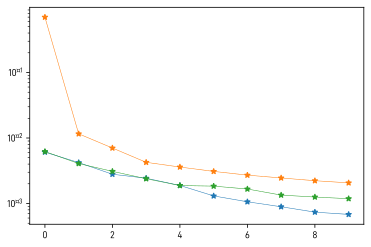

In [17]:
plt.plot(range(10), errors,'-*' , range(10), s_vals[:10], '*-' , range(10), errors_mini_2[:10],'*-' )
plt.yscale('log')

In [87]:
rgb_sgd =[0.0061,0.0042,0.0029,0.0030,0.0023,0.0019,0.0018,0.0014,0.0014,0.0011,0.0009,0.0010,0.0009,0.0008,0.0008,0.0008,0.0007,0.0007,0.0006,0.0006,0.0005,0.0005,0.0005, 0.0004, 0.0004,0.0004,0.0004,0.0003,0.0003,0.0003,0.0003,0.0003,0.0003,0.0003,0.0003,0.0003,0.0002,0.0002,0.0002,0.0002,0.0002,0.0002,0.0002,0.0002,0.0002,0.0002,0.0002,0.0002,0.0001, 0.0001, 0.0001, 0.0001]

In [88]:
len(rgb_sgd)

52

In [90]:
open('graph_kernel_sgd_losses.pickle', 'wb').write(pickle.dumps(rgb_sgd))

484

In [75]:
len(errors_mini)

19

In [74]:
errors_mini+errors_mini_1

[0.0061804,
 0.0046355,
 0.0038087,
 0.0030982,
 0.0021956,
 0.0021081,
 0.0014806,
 0.0015258,
 0.0010862,
 0.0010517,
 0.0009961,
 0.0009438,
 0.0008429,
 0.0007509,
 0.0006723,
 0.0006414,
 0.0007446,
 0.0006746,
 0.0006916,
 0.0006358,
 0.0002089,
 0.0001358,
 0.0001128,
 0.0001089,
 0.0001019,
 0.0001083,
 0.0001056]

In [19]:
ran = [1, 5, 10,15,20,40,60,80,100,120,140,160]

In [95]:
zz = errors_mini+errors_mini_1

Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does n

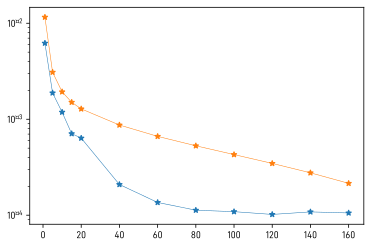

In [33]:
plt.plot(ran, aa,'-*', ran, [s_vals[t] for t in ran], '*-' )
plt.yscale('log')

In [34]:
open('gk_long_losses.pickle', 'wb').write(pickle.dumps([ran, aa, [s_vals[t] for t in ran]]))

268

In [36]:
open('gk_losses_2.pickle', 'wb').write(pickle.dumps([s_vals[1:11], errors, errors_mini_2]))

379

In [35]:
len(ran)

12

In [24]:
[s_vals[t] for t in ran]

[0.0115783,
 0.0030903,
 0.0019309,
 0.0015032,
 0.0012819,
 0.0008705,
 0.0006629,
 0.0005288,
 0.0004283,
 0.0003465,
 0.0002765,
 0.0002148]

In [29]:
aa = [errors_mini_2[0], errors_mini_2[4],errors_mini_2[9],errors_mini_2[14],0.0006358,
 0.0002089,
 0.0001358,
 0.0001128,
 0.0001089,
 0.0001019,
 0.0001083,
 0.0001056]

In [31]:
len(aa)

12